In [ ]:
!pip install necpp

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.7/196.7 kB 2.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for necpp: filename=necpp-1.7.3.5-cp310-cp310-linux_x86_64.whl size=1705695 sha256=0915bbd70ae3b76a7d8aad59d263084013af013c93a5aa9d78f216ea867660d1
  Stored in directory: /root/.cache/pip/wheels/fb/b3/e6/144c1d235957bca3e4cf1d2daf841a0f283418e6b12bea626e
Successfully built necpp


In [ ]:
!pip3 install PyNEC==1.7.3.4

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 219.0/219.0 kB 3.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for PyNEC: filename=PyNEC-1.7.3.4-cp310-cp310-linux_x86_64.whl size=2087515 sha256=a633e7772b2170527aa88bdf478085c3f8a4e0d9fd134d33e9d9d5246c90ca50
  Stored in directory: /root/.cache/pip/wheels/a0/2b/70/64681dd13f39205610be54c7810f9167bcb3173c8549621d95
Successfully built PyNEC


In [ ]:
import necpp
import math
import random
import numpy as np
import time

In [ ]:
def handle_nec(result):
  if (result != 0):
    pass

maxSize=1

In [ ]:
def objective(x1, y1, z1, x2, y2, z2, x3, y3, z3, thickness, freq):
  if any([abs(mes)>maxSize for mes in [x1, y1, z1, x2, y2, z2, x3, y3, z3]]):
    return -999
  nec=necpp.nec_create()

  handle_nec(necpp.nec_wire(nec, 1, 15, 0.0, 0.0, 0.0, x1, y1, z1, thickness, 1.0, 1.0))
  handle_nec(necpp.nec_wire(nec, 1, 15, x1, y1, z1, x2, y2, z2, thickness, 1.0, 1.0))
  handle_nec(necpp.nec_wire(nec, 1, 15, x2, y2, z2, x3, y3, z3, thickness, 1.0, 1.0))

  handle_nec(necpp.nec_geometry_complete(nec, 0))

  handle_nec(necpp.nec_fr_card(nec, 0, 1, freq/1000000, 0.0))
  handle_nec(necpp.nec_ld_card(nec, 5, 0, 0, 0, 1.45e6, 0.0, 0.0))
  handle_nec(necpp.nec_gn_card(nec, 1, 0, 0, 0, 0, 0, 0, 0))
  handle_nec(necpp.nec_ex_card(nec, 0, 1, 1, 0, 1.0, 0, 0, 0, 0, 0))
  handle_nec(necpp.nec_rp_card(nec, 0, 17, 45, 0, 5, 0, 0, 0, 0, 5, 8, 0, 0))

  maxGain = necpp.nec_gain_mean(nec, 0)
  impedance = necpp.nec_impedance_real(nec, 0)
  reactance = necpp.nec_impedance_imag(nec, 0)
  reflection_coeff = abs((impedance-50)/(impedance+50))
  transmission_coeff = 1 - reflection_coeff

  necpp.nec_delete(nec)

  return (maxGain/15 + transmission_coeff*1.1 - abs(reactance)/30)/2

In [ ]:
wThickness = 0.002
frequency = 5000000000
num_segments = 3
num_params = 3*num_segments

wavelength = 299792458.0/frequency

def random_matrix():
  referenceCord = 0
  x_init = np.random.rand(num_params, 1)

  for i in range(num_params):
    if i==0 or i==2:
      x_init[i, 0] = x_init[i, 0]*wavelength*2*1.732050808/3 - wavelength*1.732050808/3
    if i==1:
      x_init[i, 0] = x_init[i, 0]*wavelength*1.732050808/3
    if i>1 and i!=2:
      x_init[i, 0] = x_init[referenceCord, 0] + x_init[referenceCord+3, 0]*2*1.732050808/3 - wavelength*1.732050808/3
      referenceCord+=1
  return x_init

x_init = random_matrix()

In [ ]:
import gaussian_process_regression as gpr
import gradient_ascent as ga
from scipy.stats import norm
from tqdm import tqdm

In [ ]:
X=[x_init[:,0]]
y = [objective(x_init[0,0], x_init[1,0], x_init[2,0], x_init[3,0], x_init[4,0], x_init[5,0], x_init[6,0], x_init[7,0], x_init[8,0], wThickness, frequency)]
max_y = y[0]

gamma = 0.95
gamma_decay = 0.85

max_iterations=25

def surrogate_obj(x_star):
  mu, sigma = gpr.inference(x_star, np.array(X), np.array(y), gpr.squared_exponential)
  #print(mu)
  mu=mu[0]
  sigma=sigma[0,0]
  try:
    z = (max_y-mu)/(math.sqrt(sigma))
  except:
    print(sigma)
    return -999
  p = 1-norm.cdf(z)
  return (1-gamma)*p + gamma*sigma

 16%|█▌        | 4/25 [00:15<01:22,  3.94s/it]


KeyboardInterrupt: ignored

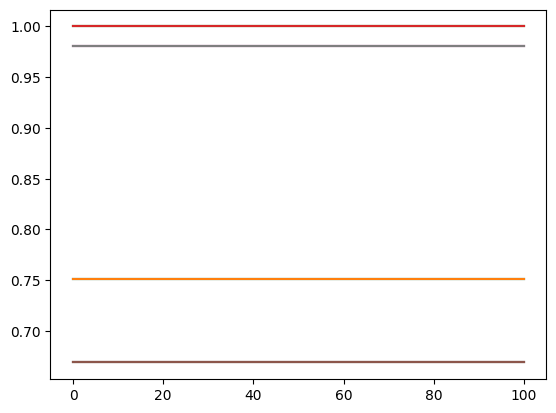

In [ ]:
for i in tqdm(range(max_iterations)):
  best_x_star = [ga.gradientAscent(surrogate_obj, (num_params,1), min_x=-1, max_x=1)[0] for best_x_not in range(4)]
  best = np.argmax([surrogate_obj(xga) for xga in best_x_star])
  best_x_star = best_x_star[best]

  for xval in X:
    diff = best_x_star-xval.reshape((num_params, 1))
    square = np.matmul(np.transpose(diff), diff)
    #print(square)
    if square<1e-4:
      print("gabbayabba")
      best_x_star = random_matrix()
  X.append(best_x_star[:,0])
  y.append(objective(best_x_star[0,0], best_x_star[1,0], best_x_star[2,0], best_x_star[3,0], best_x_star[4,0], best_x_star[5,0], best_x_star[6,0], best_x_star[7,0], best_x_star[8,0], wThickness, frequency))
  max_y = np.max(y)
  gamma *= gamma_decay

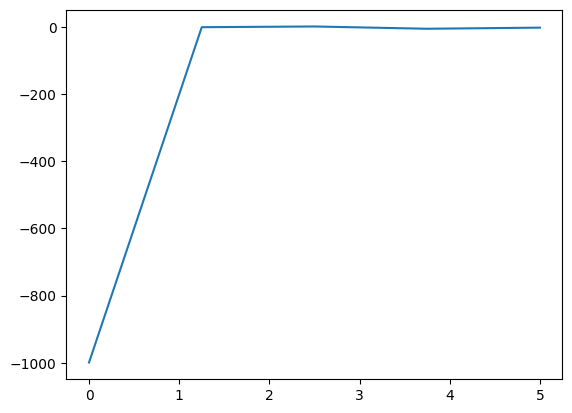

In [ ]:
times = np.linspace(0, len(y), len(y))
from matplotlib import pyplot as plt
plt.plot(times, y)

In [ ]:
max_x_i = np.argmax(y)
true_best_found = X[max_x_i]
print(true_best_found)
print(y[max_x_i])

[ 9.08241630e-01 -9.56994305e-01  4.18890041e-04  5.95596760e-01
 -2.40626371e-02 -5.34008091e-01 -7.33608252e-02 -1.45972986e-01
  1.66683737e-01]
0.8230186842526143


In [ ]:

#add wires to the geometry

W = true_best_found
x1,y1,z1,x2,y2,z2,x3,y3,z3 = W[0], W[1], W[2], W[3], W[4], W[5], W[6], W[7], W[8]

nec=necpp.nec_create()

handle_nec(necpp.nec_wire(nec, 1, 15, 0.0, 0.0, 0.0, x1, y1, z1, wThickness, 1.0, 1.0))
handle_nec(necpp.nec_wire(nec, 1, 15, x1, y1, z1, x2, y2, z2, wThickness, 1.0, 1.0))
handle_nec(necpp.nec_wire(nec, 1, 15, x2, y2, z2, x3, y3, z3, wThickness, 1.0, 1.0))

handle_nec(necpp.nec_geometry_complete(nec, 0))

handle_nec(necpp.nec_fr_card(nec, 0, 1, frequency/1000000, 0.0))
handle_nec(necpp.nec_ld_card(nec, 5, 0, 0, 0, 1.45e6, 0.0, 0.0))
handle_nec(necpp.nec_gn_card(nec, 1, 0, 0, 0, 0, 0, 0, 0))
handle_nec(necpp.nec_ex_card(nec, 0, 1, 1, 0, 1.0, 0, 0, 0, 0, 0))
handle_nec(necpp.nec_rp_card(nec, 0, 17, 45, 0, 5, 0, 0, 0, 0, 5, 8, 0, 0))

maxGain = necpp.nec_gain_max(nec, 0)
meanGain = necpp.nec_gain_mean(nec, 0)
impedance = necpp.nec_impedance_real(nec, 0)
print(necpp.nec_impedance_imag(nec, 0))
reflection_coeff = abs((impedance-50)/(impedance+50))
transmission_coeff = 1 - reflection_coeff


print(maxGain)
print(meanGain)
print(impedance)
print(transmission_coeff)

val = maxGain/20 + transmission_coeff
print(val/2)
#print(maxGain/20 + transmission_coeff)/2

0.8643777844916515
38.9660981287411
24.58339748005667
0.8307781452280127
0.03268799634955044
0.9904964513933028


8.0


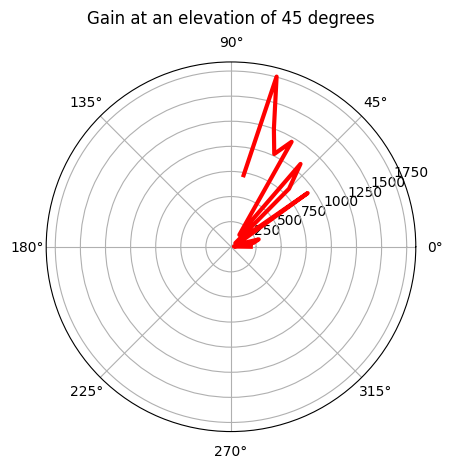

In [ ]:
from PyNEC import *
import numpy as np

#creation of a nec context
context=nec_context()

#get the associated geometry
geo = context.get_geometry()

#add wires to the geometry
geo.wire(1, 15, 0.0, 0.0, 0.0, x1, y1, z1, wThickness, 1.0, 1.0)
geo.wire(1, 15, x1, y1, z1, x2, y2, z2, wThickness, 1.0, 1.0)
geo.wire(1, 15, x2, y2, z2, x3, y3, z3, wThickness, 1.0, 1.0)
context.geometry_complete(0)

context.gn_card(1, 0, 0, 0, 0, 0, 0, 0)

#add a "ex" card to specify an excitation
context.ex_card(0, 1, 1, 0, 1.0, 0, 0, 0, 0, 0)
context.ld_card(5, 0, 0, 0, 1.45e6, 0.0, 0.0)

#add a "fr" card to specify the frequency
context.fr_card(0, 1, frequency/1000000, 0.0)

#add a "rp" card to specify radiation pattern sampling parameters and to cause program execution
context.rp_card(0, 17, 45, 0, 5, 0, 0, 0, 0, 5, 8, 0, 0)

#get the radiation_pattern
rp = context.get_radiation_pattern(0)

# Gains are in decibels
gains_db = rp.get_gain()
#print(gains_db)
gains = 10.0**(gains_db / 10.0)
thetas = rp.get_theta_angles() * 3.1415 / 180.0
phis = rp.get_phi_angles() * 3.1415 / 180.0

print(rp.get_delta_phi())
# Plot stuff
import matplotlib.pyplot as plt

ax = plt.subplot(111, polar=True)
ax.plot(thetas, gains[:,39], color='r', linewidth=3)
ax.grid(True)

ax.set_title("Gain at an elevation of 45 degrees", va='bottom')
plt.savefig('RadiationPattern.png')
plt.show()


In [ ]:

print(np.argmax(gains))
print(np.max(gains_db))
print(np.min(gains_db))
print(gains[12, :])

711
38.9660981287411
11.294105787713505
[1260.30972567 2017.75272187 2006.84595743 1780.75547291  199.82505122
  314.17601198 1111.29097876  933.6984257   379.97413154  652.25980847
  221.81623947  232.94690897  285.19528164  173.15537496  159.95593897
  358.95360479  807.50373585  316.64481972  447.51755567  143.72140091
  112.85044031  281.62111577   39.82219393  399.18793831  894.04458316
  336.81090285   67.71514875  287.89645301  247.87668964 2417.35166115
  651.95798873  430.2058699   753.57793667  872.94129428 4083.77916883
 3370.81237059   59.28171639 1945.42236312 4415.46101308 1207.40028951
  199.56418499  786.72506318  446.80088242 2934.71148457  200.91737065]


<ipython-input-49-429632a09d01>:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd), label='Gain')


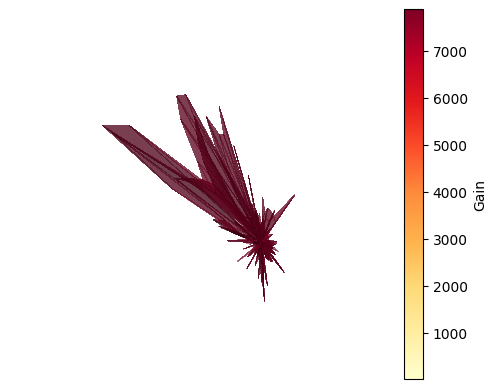

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib


THETA, PHI = np.meshgrid(thetas, phis)
#R = np.cos(PHI**2)
gains_plot=np.transpose(gains)
X = np.multiply(gains_plot, np.sin(PHI) * np.cos(THETA))
Y = np.multiply(gains_plot, np.sin(PHI) * np.sin(THETA))
Z = np.multiply(gains_plot, np.cos(PHI))
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.axis('off')
ax.view_init(45, 10)

minn, maxx = gains_plot.min(), gains_plot.max()
norm = matplotlib.colors.Normalize(minn, maxx)
'''
ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=fc)'''

plot = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, facecolors=cm.YlOrRd(gains_plot),
    linewidth=0, antialiased=False, alpha=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd), label='Gain')
plt.show()

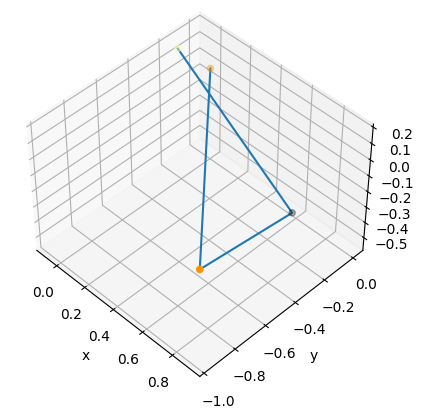

In [ ]:
xs = [0, x1, x2, x3]
ys = [0, y1, y2, y3]
zs = [0, z1, z2, z3]
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')
ax.plot3D(xs, ys, zs)
ax.scatter3D(xs, ys, zs, cmap=plt.get_cmap('inferno'), c=zs)
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.view_init(45, -45)
plt.show()

In [ ]:
import necpp
#add wires to the geometry

wThickness = 0.002/2
frequency = 2634000#5000000000
#num_segments = 3
#num_params = 3*num_segments

wavelength = 299792458.0/frequency

nec=necpp.nec_create()

handle_nec(necpp.nec_wire(nec, 1, 15, 0.0, 0.0, 0.0, 0.0, 0.015, 0.0, wThickness, 1.0, 1.0))
handle_nec(necpp.nec_wire(nec, 1, 15, 0.0, .015, 0.0, 0.0, 0.015, 0.11, wThickness, 1.0, 1.0))

handle_nec(necpp.nec_geometry_complete(nec, 0))

handle_nec(necpp.nec_fr_card(nec, 0, 1, frequency/1000000, 0.0))
handle_nec(necpp.nec_ld_card(nec, 5, 0, 0, 0, 1.45e6, 0.0, 0.0))
handle_nec(necpp.nec_gn_card(nec, 1, 0, 0, 0, 0, 0, 0, 0))
handle_nec(necpp.nec_ex_card(nec, 0, 1, 1, 0, 1.0, 0, 0, 0, 0, 0))
handle_nec(necpp.nec_rp_card(nec, 0, 17, 45, 0, 5, 0, 0, 0, 0, 5, 8, 0, 0))

maxGain = necpp.nec_gain_max(nec, 0)
meanGain = necpp.nec_gain_mean(nec, 0)
impedance = necpp.nec_impedance_real(nec, 0)
print(necpp.nec_impedance_imag(nec, 0))
reflection_coeff = abs((impedance-50)/(impedance+50))
transmission_coeff = 1 - reflection_coeff


print(maxGain)
print(meanGain)
print(impedance)
print(transmission_coeff)

val = maxGain/20 + transmission_coeff
print(val/2)
#print(maxGain/20 + transmission_coeff)/2

-0.028073125842851685
-9.703252851608827
-17.67017063448842
0.004877931960600851
0.00019509824490471228
-0.2424837721677683


8.0


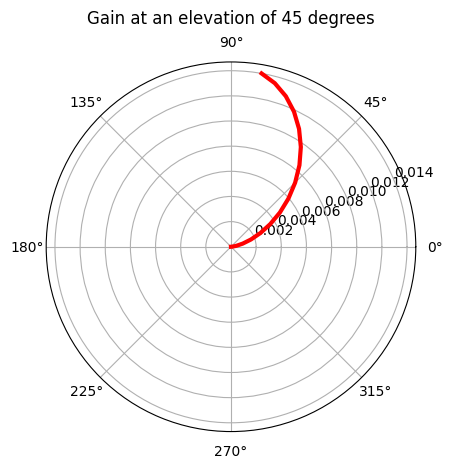

In [ ]:
from PyNEC import *
import numpy as np

#creation of a nec context
context=nec_context()

#get the associated geometry
geo = context.get_geometry()

#add wires to the geometry
geo.wire(1, 15, 0.0, 0.0, 0.0, 0.0, .015, 0.0, wThickness, 1.0, 1.0)
geo.wire(1, 15, 0.0, .015, 0.0, 0.0, 0.015, 0.06, wThickness, 1.0, 1.0)
context.geometry_complete(0)

context.gn_card(1, 0, 0, 0, 0, 0, 0, 0)

#add a "ex" card to specify an excitation
context.ex_card(0, 1, 1, 0, 1.0, 0, 0, 0, 0, 0)
context.ld_card(5, 0, 0, 0, 1.45e6, 0.0, 0.0)

#add a "fr" card to specify the frequency
context.fr_card(0, 1, frequency/1000000, 0.0)

#add a "rp" card to specify radiation pattern sampling parameters and to cause program execution
context.rp_card(0, 17, 45, 0, 5, 0, 0, 0, 0, 5, 8, 0, 0)

#get the radiation_pattern
rp = context.get_radiation_pattern(0)

# Gains are in decibels
gains_db = rp.get_gain()
#print(gains_db)
gains = 10.0**(gains_db / 10.0)
thetas = rp.get_theta_angles() * 3.1415 / 180.0
phis = rp.get_phi_angles() * 3.1415 / 180.0

print(rp.get_delta_phi())
# Plot stuff
import matplotlib.pyplot as plt

ax = plt.subplot(111, polar=True)
ax.plot(thetas, gains[:,0], color='r', linewidth=3)
ax.grid(True)

ax.set_title("Gain at an elevation of 45 degrees", va='bottom')
plt.savefig('RadiationPattern.png')
plt.show()


<ipython-input-16-3e1c37152c6f>:33: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  fig.colorbar(cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd), label='Gain')


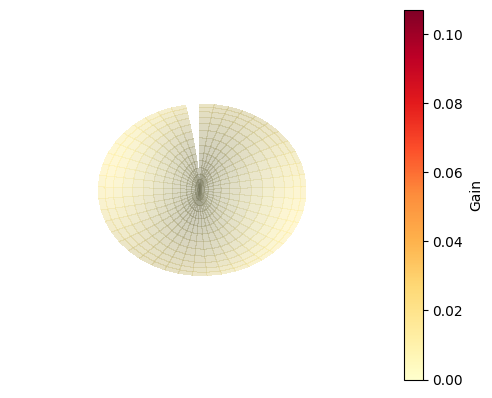

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d.axes3d as axes3d
import matplotlib.cm as cm
from matplotlib.colors import Normalize
import matplotlib


THETA, PHI = np.meshgrid(thetas, phis)
#R = np.cos(PHI**2)
gains_plot=np.transpose(gains)
X = np.multiply(gains_plot, np.sin(PHI) * np.cos(THETA))
Y = np.multiply(gains_plot, np.sin(PHI) * np.sin(THETA))
Z = np.multiply(gains_plot, np.cos(PHI))
fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])
ax.axis('off')
ax.view_init(0, 0)

minn, maxx = gains_plot.min(), gains_plot.max()
norm = matplotlib.colors.Normalize(minn, maxx)
'''
ax = fig.add_subplot(222, projection='3d')
ax.plot_surface(X, Y, Z, facecolors=fc)'''

plot = ax.plot_surface(
    X, Y, Z, rstride=1, cstride=1, facecolors=cm.YlOrRd(gains_plot),
    linewidth=0, antialiased=False, alpha=0.5)
fig.colorbar(cm.ScalarMappable(norm=norm, cmap=plt.cm.YlOrRd), label='Gain')
plt.show()